In [1]:
import os
import json
import numpy as np
import xarray as xr
import geopandas as gpd

import cartopy.crs as ccrs

from multiprocessing import Pool

from playsound import playsound

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '1dy'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'IMERG', '3h'
# product, time_reso = 'PERSIANN', '1dy'
# product, time_reso = 'MSWEP', '3h'
product, time_reso = 'SM2RAIN', '1dy'
# product, time_reso = 'GSMaP', '3h'

if product == 'SM2RAIN':
    yy_s, yy_e = 2007, 2012
    # yy_s, yy_e = 2007, 2022
    year_vector = np.arange(yy_s, yy_e+1)
else:
    yy_s, yy_e = 2002, 2012
    # yy_s, yy_e = 2002, 2023
    year_vector = np.arange(yy_s, yy_e+1)

years_num = yy_e - yy_s + 1
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : SM2RAIN_1dy.json
Number of threads: 20
Neighborhood area: 5x5



In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

## Load DATA

In [6]:
print(f'Reading Data File : {param['file']}') 
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_data = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

time_vector = PRE_data['time'].data

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data
lon2d, lat2d = np.meshgrid(lons, lats)

PRE_data

Reading Data File : SM2RAIN_ASCAT_Italy_1dy_2007_01_01_2022_12_31.nc


<xarray.Dataset> Size: 14MB
Dimensions:  (time: 2192, lat: 26, lon: 31)
Coordinates:
  * time     (time) datetime64[ns] 18kB 2007-01-01 2007-01-02 ... 2012-12-31
  * lat      (lat) float32 104B 47.0 46.9 46.8 46.7 46.6 ... 44.8 44.7 44.6 44.5
  * lon      (lon) float32 124B 10.5 10.6 10.7 10.8 10.9 ... 13.2 13.3 13.4 13.5
Data variables:
    PRE      (time, lat, lon) float32 7MB ...
    NOISE    (time, lat, lon) float32 7MB ...
Attributes:
    description:  SM2RAIN ASCAT daily data for Italy region

Text(0.0, 1.0, '(c) Daily maximum rainfall')

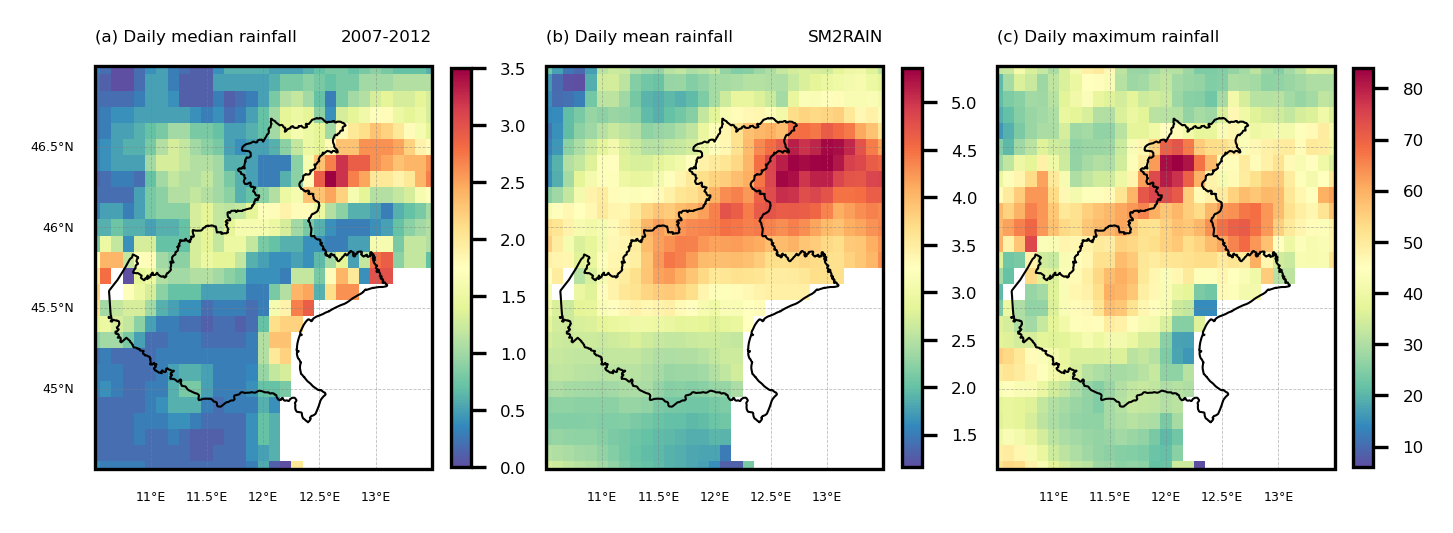

In [7]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5.5,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, PRE_data['PRE'].median(dim='time'),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Daily median rainfall', fontsize=4, loc='left')
ax1.set_title(f'{yy_s}-{yy_e}', fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, PRE_data['PRE'].mean(dim='time'),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Daily mean rainfall', fontsize=4, loc='left')
ax1.set_title(product, fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, PRE_data['PRE'].max(dim='time'),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Daily maximum rainfall', fontsize=4, loc='left')

## Yearly Weibull Parameters

In [8]:
num_processes = max(1, os.cpu_count() - 2)

def process_point(args):
    i, j, PRE_data, lats, lons = args
    TMP = ART_down.weibull_year_parameters(PRE_data, lats[i], lons[j], 1, 50)
    return i, j, TMP

# Crear lista de argumentos
args = [(i, j, PRE_data, lats, lons) for i in range(len(lats)) for j in range(len(lons))]

# Paralelizar cálculos
with Pool(processes=num_processes) as pool:
    results = pool.map(process_point, args)

# Recolectar resultados
N = np.zeros([years_num, len(lats), len(lons)])
C = np.zeros([years_num, len(lats), len(lons)])
W = np.zeros([years_num, len(lats), len(lons)])

for i, j, TMP in results:
    N[:, i, j] = TMP[:, 0]
    C[:, i, j] = TMP[:, 1]
    W[:, i, j] = TMP[:, 2]

Text(0.0, 1.0, '(c) Mean of Shape parameter')

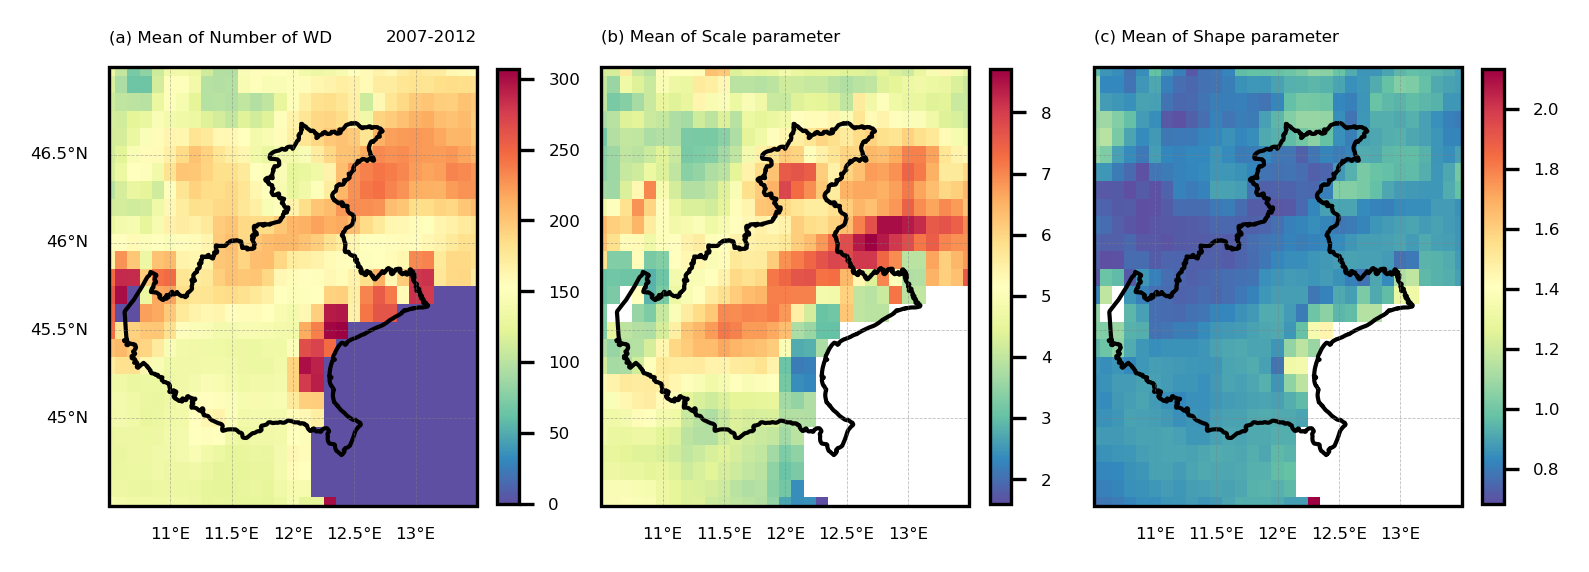

In [9]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(N,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Mean of Number of WD', fontsize=4, loc='left')
ax1.set_title(f'{yy_s}-{yy_e}', fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(C,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Mean of Scale parameter', fontsize=4, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(W,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Mean of Shape parameter', fontsize=4, loc='left')


## Load BETA

In [10]:
BETA_file = f'VENETO_BETA_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{NEIBHR}.nc'
dir_input = os.path.join(dir_base,'1_BETA',BETA_file)
print(f'Reading Beta File : {BETA_file}') 

DATA = xr.open_dataset(dir_input)

BETA = DATA['BETA'].values

del DATA

Reading Beta File : VENETO_BETA_SM2RAIN_1dy_2007_2012_npix_5.nc


## Load GAMMA

In [11]:
GAMMA_file = f'VENETO_GAMMA_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{NEIBHR}.nc'
dir_input = os.path.join(dir_base,'2_GAMMA',GAMMA_file)
print(f'Reading Gamma File: {GAMMA_file}') 

DATA = xr.open_dataset(dir_input)

GAMMA = DATA['GAMMA'].values

del DATA

Reading Gamma File: VENETO_GAMMA_SM2RAIN_1dy_2007_2012_npix_5.nc


In [12]:
val_ = np.nan
val_ = -999.9
if product == 'SM2RAIN':
    print('Remove NaN and negatives values in BETA and GAMMA')
    mask = ~np.isnan(PRE_data['PRE'].median(dim='time').values)
    BETA = xr.where(mask, BETA, val_)
    BETA = xr.where((BETA < 0)|(BETA > 1.6), val_, BETA)
    mask = ~np.isnan(BETA)
    GAMMA = xr.where(mask, GAMMA, val_)

Remove NaN and negatives values in BETA and GAMMA


Export figure to: ../figures/BETA_GAMMA/VENETO_SM2RAIN_beta_gamma_1dy_npix_5_2007_2012.png


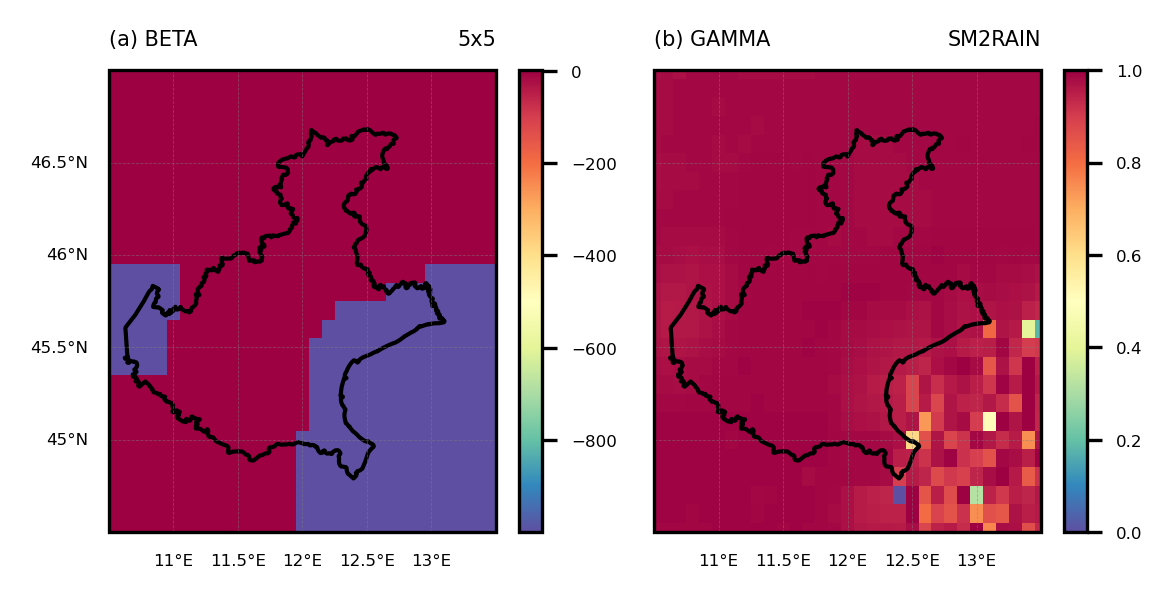

In [13]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4.3,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, BETA, cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) BETA', fontsize=5, loc='left')
ax1.set_title(f'{NEIBHR}x{NEIBHR}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, GAMMA, cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) GAMMA', fontsize=5, loc='left')
ax1.set_title(f'{product}', fontsize=5, loc='right')

salida = os.path.join('..','figures','BETA_GAMMA',f'VENETO_{product}_beta_gamma_{time_reso}_npix_{NEIBHR}_{yy_s}_{yy_e}.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

## Downscale parameters

In [14]:
print(f'BETA mean: {np.nanmean(BETA)}')
print(f'GAMMA mean: {np.nanmean(GAMMA)}')

BETA mean: -304.40388798621103
GAMMA mean: 0.9721741977450157


In [15]:
Nd, Cd, Wd = ART_down.down_year_parameters(N, C, W, BETA, GAMMA)

warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there

/home/arturo/github/downpy/function/ART_downscale.py:386: RuntimeWarning: divide by zero encountered in scalar divide
  rhs = (1/(gam*beta)) * (((2*ws*gamma(2 / ws))/((gamma(1/ws))**2)) + (gam-1)*pws)


Text(0.0, 1.0, '(c) Mean of D-Shape')

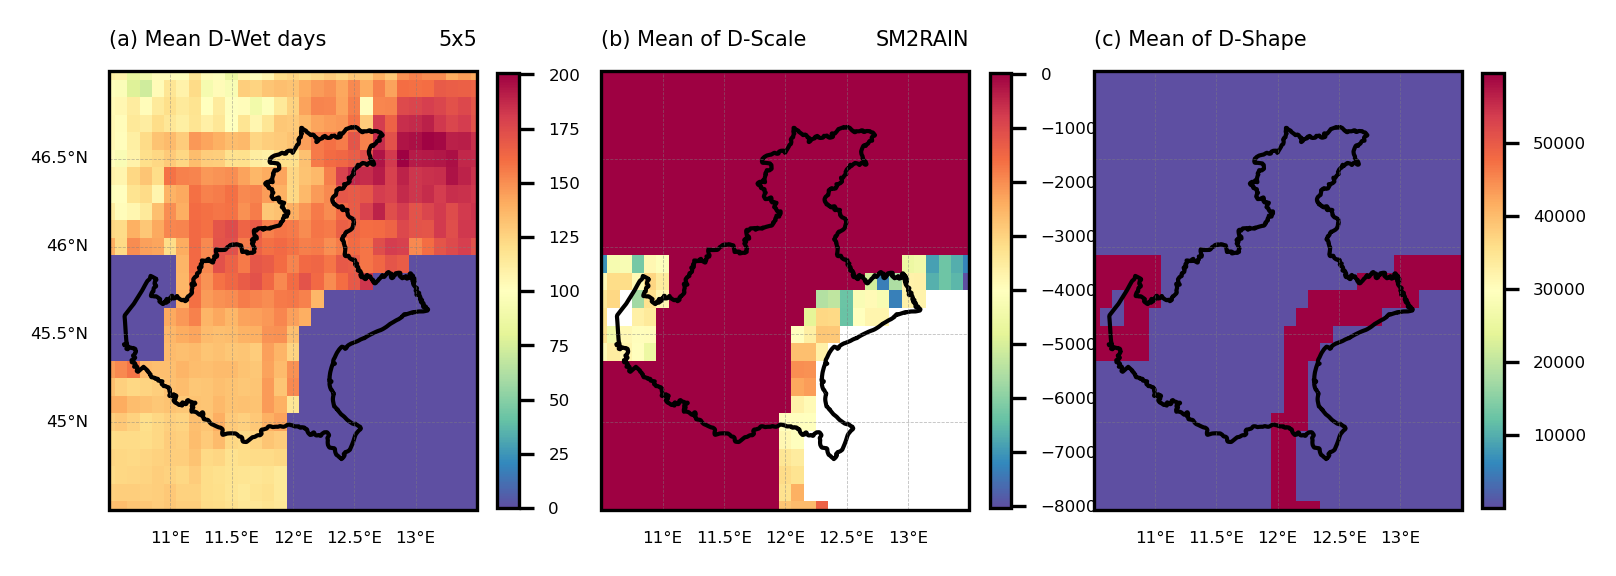

In [16]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(Nd,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Mean D-Wet days', fontsize=5, loc='left')
ax1.set_title(f'{NEIBHR}x{NEIBHR}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(Cd,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Mean of D-Scale', fontsize=5, loc='left')
ax1.set_title(f'{product}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(Wd,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Mean of D-Shape', fontsize=5, loc='left')


In [17]:
# Tr = [10, 100, 200] # Project Tr
Tr = [10, 20, 50, 100, 200]
QUANTILE = ART_down.pre_quantiles_array(Nd, Cd, Wd, Tr, lats, lons, 1)

ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve d

/home/arturo/github/downpy/function/ART_downscale.py:414: RuntimeWarning: invalid value encountered in power
  mev0f = np.sum( ( 1-np.exp(-(y/C)**W ))**N) - nyears*pr
/home/arturo/github/downpy/function/ART_downscale.py:414: RuntimeWarning: overflow encountered in power
  mev0f = np.sum( ( 1-np.exp(-(y/C)**W ))**N) - nyears*pr
/home/arturo/github/downpy/function/ART_downscale.py:491: RuntimeWarning: Mean of empty slice
  x0 = 9.0*np.nanmean(data_tmp)


In [18]:
if product == 'SM2RAIN':
    QUANTILE = xr.where(QUANTILE < 0, 0, QUANTILE)

Export figure to: ../figures/Tr/VENETO_SM2RAIN_Tr_1dy_npix_5_2007_2012.png


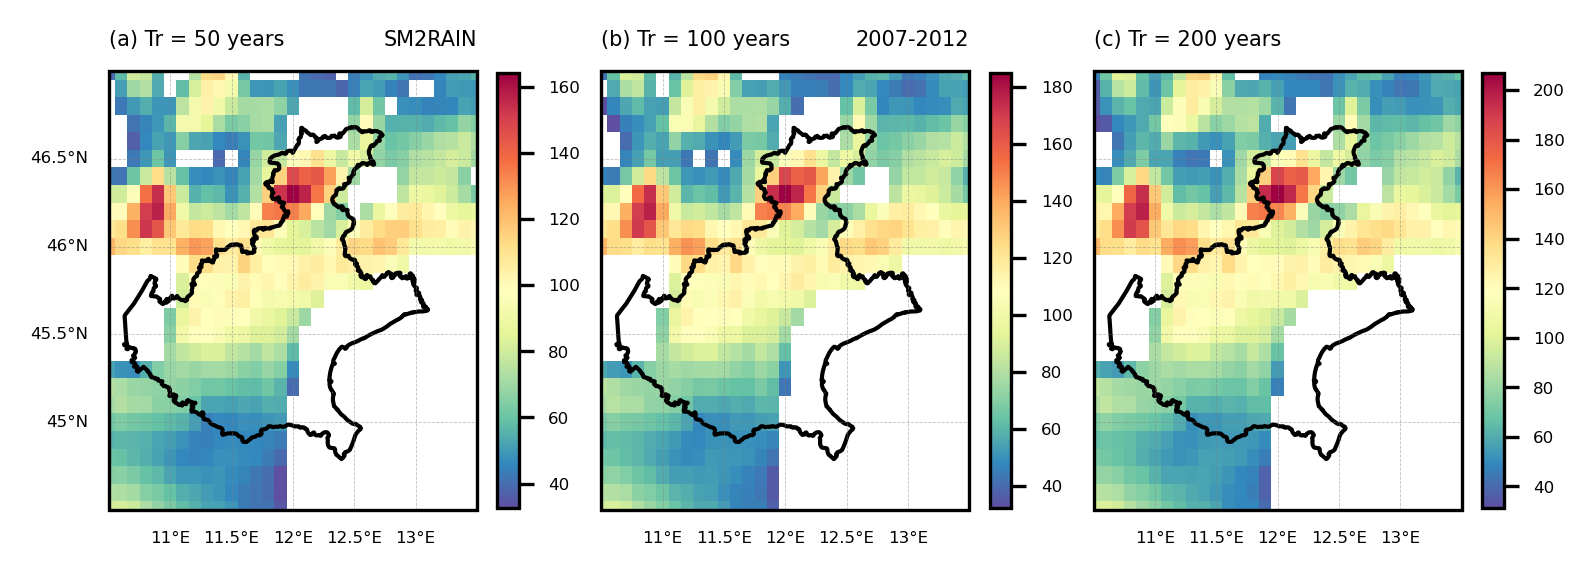

In [19]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, QUANTILE[2,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Tr = {Tr[2]} years', fontsize=5, loc='left')
ax1.set_title(f'{product}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, QUANTILE[3,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Tr = {Tr[3]} years', fontsize=5, loc='left')
ax1.set_title(f'{yy_s}-{yy_e}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, QUANTILE[4,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Tr = {Tr[4]} years', fontsize=5, loc='left')

salida = os.path.join('..','figures','Tr',f'VENETO_{product}_Tr_{time_reso}_npix_{NEIBHR}_{yy_s}_{yy_e}.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [20]:
DOWN_xr = xr.Dataset(data_vars={
                    "N": (("year","lat","lon"), N),
                    "C": (("year","lat","lon"), C),
                    "W": (("year","lat","lon"), W),
                    "Nd": (("year","lat","lon"), Nd),
                    "Cd": (("year","lat","lon"), Cd),
                    "Wd": (("year","lat","lon"), Wd),
                    "Quantile": (("Tr","lat","lon"), QUANTILE),
                    },
                    coords={'year':year_vector,'Tr':Tr,'lat': lats, 'lon': lons},
                    attrs=dict(description=f"Yearly Weibull Paramaters Downscale using {product} for Veneto region limited as 10.5E to 13.5E and 44.5N to 47N"))

DOWN_xr.N.attrs["units"] = "day"
DOWN_xr.N.attrs["long_name"] = "Number of wet days"
DOWN_xr.N.attrs["origname"] = "wet days"

DOWN_xr.C.attrs["units"] = "dimensionless"
DOWN_xr.C.attrs["long_name"] = "Weibull scale parameter"
DOWN_xr.C.attrs["origname"] = "scale"

DOWN_xr.W.attrs["units"] = "dimensionless"
DOWN_xr.W.attrs["long_name"] = "Weibull shape parameter"
DOWN_xr.W.attrs["origname"] = "shape"

DOWN_xr.Nd.attrs["units"] = "day"
DOWN_xr.Nd.attrs["long_name"] = "Downscale Number of wet days"
DOWN_xr.Nd.attrs["origname"] = "down wet days"

DOWN_xr.Cd.attrs["units"] = "dimensionless"
DOWN_xr.Cd.attrs["long_name"] = "Downscale Weibull scale parameter"
DOWN_xr.Cd.attrs["origname"] = "down scale"

DOWN_xr.Wd.attrs["units"] = "dimensionless"
DOWN_xr.Wd.attrs["long_name"] = "Downscale Weibull shape parameter"
DOWN_xr.Wd.attrs["origname"] = "down shape"

DOWN_xr.Quantile.attrs["units"] = "mm/day"
DOWN_xr.Quantile.attrs["long_name"] = "Maximum Quantiles"
DOWN_xr.Quantile.attrs["origname"] = "quantiles"

DOWN_xr.lat.attrs["units"] = "degrees_north"
DOWN_xr.lat.attrs["long_name"] = "Latitude"

DOWN_xr.lon.attrs["units"] = "degrees_east"
DOWN_xr.lon.attrs["long_name"] = "Longitude"

In [21]:
DOWN_xr

<xarray.Dataset> Size: 265kB
Dimensions:   (year: 6, lat: 26, lon: 31, Tr: 5)
Coordinates:
  * year      (year) int64 48B 2007 2008 2009 2010 2011 2012
  * Tr        (Tr) int64 40B 10 20 50 100 200
  * lat       (lat) float32 104B 47.0 46.9 46.8 46.7 ... 44.8 44.7 44.6 44.5
  * lon       (lon) float32 124B 10.5 10.6 10.7 10.8 ... 13.2 13.3 13.4 13.5
Data variables:
    N         (year, lat, lon) float64 39kB 125.0 102.0 64.0 ... 0.0 0.0 0.0
    C         (year, lat, lon) float64 39kB 5.407 4.72 5.159 ... nan nan nan
    W         (year, lat, lon) float64 39kB 1.008 0.8903 0.7835 ... nan nan nan
    Nd        (year, lat, lon) float64 39kB 105.0 105.0 75.0 ... 0.0 0.0 0.0
    Cd        (year, lat, lon) float64 39kB 6.819 4.486 3.983 ... nan nan nan
    Wd        (year, lat, lon) float64 39kB 1.202 0.8573 0.6943 ... 0.1 0.1 0.1
    Quantile  (Tr, lat, lon) float64 32kB nan 43.45 59.12 54.82 ... nan nan nan
Attributes:
    description:  Yearly Weibull Paramaters Downscale using SM2RAIN for Venet...

In [22]:
DOWN_out = os.path.join(dir_base,'3_DOWN',f'VENETO_DOWN_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{NEIBHR}.nc')
print(f'Export PRE data to {DOWN_out}')
DOWN_xr.to_netcdf(DOWN_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/Satellite/3_DOWN/VENETO_DOWN_SM2RAIN_1dy_2007_2012_npix_5.nc


In [23]:
playsound("../sound/HOMER_DOH.mp3")